# Notebook - Ekstrasolarne planete
## K2-18b - određivanje tranzita (trajanje i dubina), perioda i spektra atmosfere
Student: Dragoljub Perišić
2025.9.21.

Ulazni fajlovi su preuzeti sa sajta: https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html

1. deo - Dužina tranzita i dubina tranzita iz fajla koji sadrži samo jedan tranzit (JWST) - batman


🔹 Plotting: jw02722-o003_t001_niriss_clear-gr700xd-substrip256_whtlt.ecsv
['MJD_UTC', 'BJD_TDB', 'whitelight_flux_order_1', 'whitelight_flux_order_2']


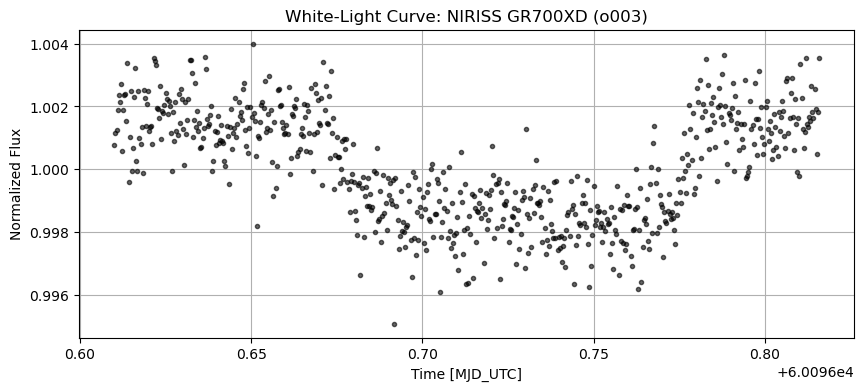

=== Transit fit (robust) ===
Estimated transit depth: 0.288 %  (2882 ppm)
Transit duration:        2.32 hours


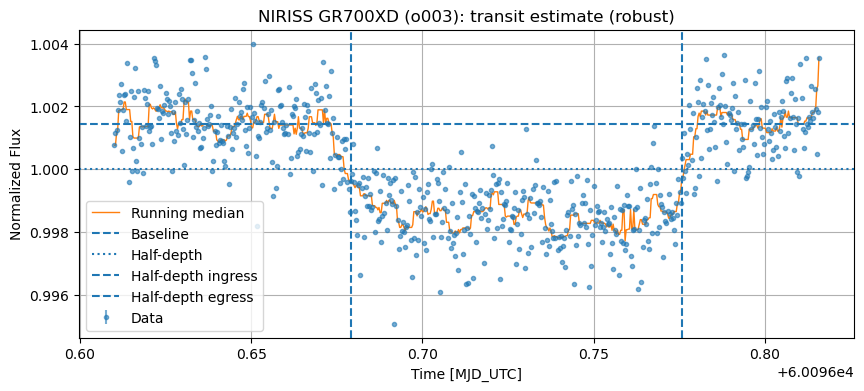

In [1]:

# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import batman
from scipy.optimize import curve_fit

#### pocetak drugog dela 
# ============================
# 2) NIRISS GR700XD (Observation o003)
# ============================
fname2 = 'jw02722-o003_t001_niriss_clear-gr700xd-substrip256_whtlt.ecsv'
print(f"\n🔹 Plotting: {fname2}")
tbl2 = Table.read(fname2, format='ascii.ecsv')
print(tbl2.colnames)

# Uzmi tražene kolone
time2 = tbl2['MJD_UTC']
flux2 = tbl2['whitelight_flux_order_1']

# Normalizuj fluks
flux2 = flux2 / np.median(flux2)

# Ako postoji kolona za grešku, koristi je – inače nule
flux_err2 = tbl2['whitelight_flux_order_1_error'] if 'whitelight_flux_order_1_error' in tbl2.colnames else np.zeros_like(flux2)

# Crtanje
plt.figure(figsize=(10, 4))
plt.errorbar(time2, flux2, yerr=flux_err2, fmt='.k', alpha=0.6)
plt.title("White-Light Curve: NIRISS GR700XD (o003)")
plt.xlabel("Time [MJD_UTC]")
plt.ylabel("Normalized Flux")
plt.grid(True)
plt.show()
# ----------------------------
# Procena dubine i trajanja tranzita (robusno, bez ekst. biblioteka)
# ----------------------------

def running_median(y, win):
    win = max(5, int(win) | 1)  # neparan prozor
    pad = win // 2
    ypad = np.pad(y, (pad, pad), mode='edge')
    return np.array([np.median(ypad[i:i+win]) for i in range(len(y))])

def nearest_index(x, val):
    return int(np.argmin(np.abs(x - val)))

# 1) Glatkanje i centar tranzita
sm = running_median(flux2, max(5, len(flux2)//50))
imin = int(np.argmin(sm))
t_center = time2[imin]

# 2) Inicijalne procene baseline i dubine iz percentila (uvek postoje)
baseline0 = float(np.percentile(flux2, 80))   # robustan "gornji" nivo
low_p = float(np.percentile(flux2, 5))        # donjih 5% kao "dno"
depth0 = max(1e-6, baseline0 - low_p)         # inicijalna dubina (nikad 0)
half_level0 = baseline0 - depth0/2.0

# 3) Pronađi half-depth preseke na glatkoj krivi (levo/desno od minimuma)
#    Ako nema preseka, fallback koristi fiksni prozor oko minimuma.
cross_left = None
for i in range(imin-1, 0, -1):
    if (sm[i] <= half_level0) and (sm[i-1] > half_level0):
        f1, f0 = sm[i], sm[i-1]
        t1, t0i = time2[i], time2[i-1]
        frac = (half_level0 - f0) / (f1 - f0 + 1e-18)
        cross_left = t0i + frac * (t1 - t0i)
        break

cross_right = None
for i in range(imin, len(time2)-1):
    if (sm[i] <= half_level0) and (sm[i+1] > half_level0):
        f0, f1 = sm[i], sm[i+1]
        t0i, t1 = time2[i], time2[i+1]
        frac = (half_level0 - f0) / (f1 - f0 + 1e-18)
        cross_right = t0i + frac * (t1 - t0i)
        break

# Fallback: simetrični prozor ako preseci nisu nađeni
if cross_left is None or cross_right is None or cross_right <= cross_left:
    w_guess_days = 0.15  # ~3.6 h
    cross_left = t_center - w_guess_days
    cross_right = t_center + w_guess_days

# 4) Definiši segment tranzita i OOT
s_it = max(0, nearest_index(time2, cross_left))
e_it = min(len(time2)-1, nearest_index(time2, cross_right))
if s_it >= e_it:
    # još jedan fallback: bar nekoliko tačaka oko minimuma
    halfw = max(3, len(time2)//200)
    s_it = max(0, imin - halfw)
    e_it = min(len(time2)-1, imin + halfw)

it_seg = slice(s_it, e_it+1)
oot_mask = np.ones(len(time2), dtype=bool)
oot_mask[it_seg] = False

# 5) Baseline i dubina iz segmenata (robustno)
#    Ako se desi da je OOT malo, uzmi gornjih 50% flukseva kao baseline
if np.any(oot_mask):
    baseline = np.median(flux2[oot_mask])
else:
    baseline = np.median(flux2[flux2 >= np.percentile(flux2, 50)])

fin = flux2[it_seg]
if len(fin) == 0:
    # ekstremni fallback: koristi najniže percentile cele serije
    fin_med = np.percentile(flux2, 5)
else:
    fin_med = np.median(fin)

depth = max(1e-9, baseline - fin_med)  # osiguraj >0
depth_rel = depth / max(1e-12, baseline)

# 6) Rafiniraj half-level i trajanje sa dobijenom dubinom
half_level = baseline - depth/2.0

# ponovo pretraži preseke ali sada oko segmenta
cross_left_ref = None
for i in range(max(1, s_it), imin+1):
    if (sm[i] <= half_level) and (sm[i-1] > half_level):
        f1, f0 = sm[i], sm[i-1]
        t1, t0i = time2[i], time2[i-1]
        frac = (half_level - f0) / (f1 - f0 + 1e-18)
        cross_left_ref = t0i + frac * (t1 - t0i)
        break

cross_right_ref = None
for i in range(imin, min(len(time2)-1, e_it+1)):
    if (sm[i] <= half_level) and (sm[i+1] > half_level):
        f0, f1 = sm[i], sm[i+1]
        t0i, t1 = time2[i], time2[i+1]
        frac = (half_level - f0) / (f1 - f0 + 1e-18)
        cross_right_ref = t0i + frac * (t1 - t0i)
        break

if cross_left_ref is None:  cross_left_ref = time2[s_it]
if cross_right_ref is None: cross_right_ref = time2[e_it]

duration_days = max(0.0, cross_right_ref - cross_left_ref)
duration_hours = duration_days * 24.0

# 7) Ispiši rezultate
print("=== Transit fit (robust) ===")
print(f"Estimated transit depth: {depth_rel*100:.3f} %  ({depth_rel*1e6:.0f} ppm)")
print(f"Transit duration:        {duration_hours:.2f} hours")

# 8) Vizuelna potvrda
plt.figure(figsize=(10, 4))
plt.errorbar(time2, flux2, yerr=flux_err2, fmt='.', alpha=0.6, label='Data')
plt.plot(time2, sm, lw=1.0, label='Running median')
plt.axhline(baseline, ls='--', label='Baseline')
plt.axhline(half_level, ls=':', label='Half-depth')
plt.axvline(cross_left_ref, ls='--', label='Half-depth ingress')
plt.axvline(cross_right_ref, ls='--', label='Half-depth egress')
plt.title("NIRISS GR700XD (o003): transit estimate (robust)")
plt.xlabel("Time [MJD_UTC]")
plt.ylabel("Normalized Flux")
plt.legend()
plt.grid(True)
plt.show()




Dobijeno trajanje tranzita : 2.32h  - dok je zvanično trajanje 2.664h
Dobijena dubina tranzita : 0.288 % (2882 ppm)  - dok je zvanično trajanje 0.27 % ≈ 2700 ppm


Drugi deo - određivanje perioda iz fajla koji koji ima dva tranzita (K2 misija) - astropy


Učitano: 3026 tačaka
----- BLS REZULTAT -----
N tačaka:           3026
Vremenski raspon:   77.334 d
Period (best):      32.80870 d
T0 (isti sistem):   56836.20897
Trajanje:           0.31363 d  (~7.53 h)
Dubina:             0.000980
BLS snaga:          2271.197


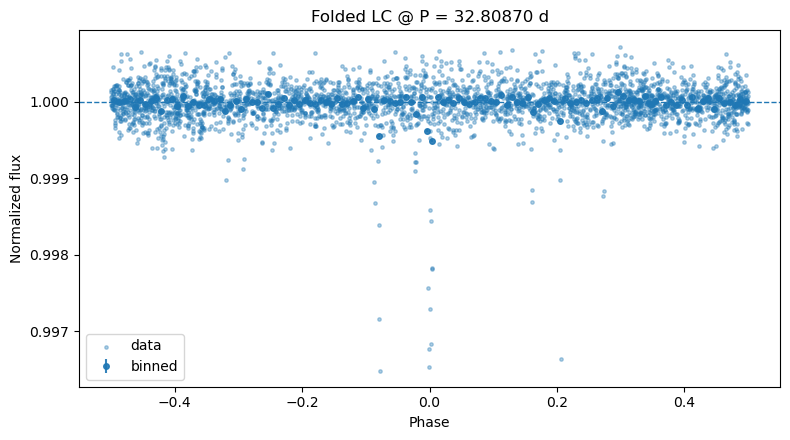

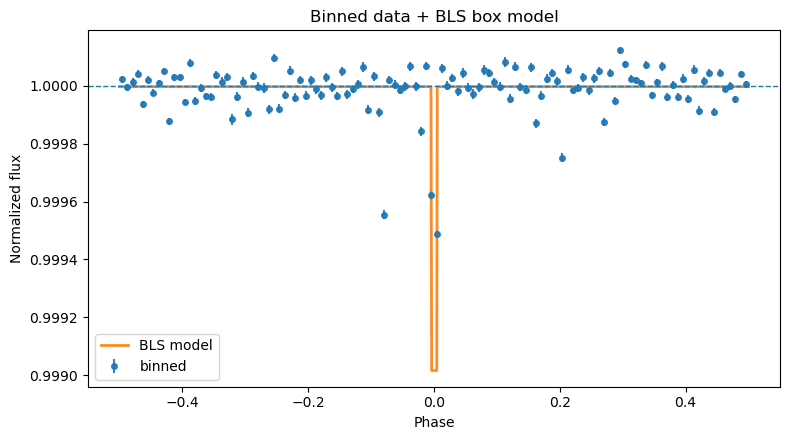

In [2]:
# === Sve u jednoj ćeliji: učitavanje + priprema + BLS + plot ===
import os, warnings
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.timeseries import BoxLeastSquares

# ---------------------------
# PODESIVO
# ---------------------------
FNAME = "hlsp_polar_k2_lightcurve_201912552-c01_kepler_v1_llc.fits"
EXT   = 1          # 1 ili 2
P_MIN, P_MAX = 30.0, 35.0       # očekivani opseg (~33 d)
N_GRID_COARSE = 2000            # gruba pretraga
N_GRID_FINE   = 3000           # fina pretraga
DUR_FRACTIONS = np.linspace(0.01, 0.12, 18)  # trajanje = frac * period

# ---------------------------
# HELPERI
# ---------------------------
def running_median(y, win_pts=201):
    if win_pts < 3:
        return y.copy()
    win = int(win_pts) | 1
    pad = win // 2
    yy  = np.pad(y, (pad, pad), mode="edge")
    out = np.empty_like(y, dtype=float)
    for i in range(len(y)):
        out[i] = np.nanmedian(yy[i:i+win])
    return out

def estimate_cadence_days(t):
    dt = np.diff(np.sort(t))
    return np.nanmedian(dt)

def phase_fold(t, per, t0):
    phase = ((t - t0 + 0.5*per) % per) / per - 0.5
    order = np.argsort(phase)
    return phase[order], order

def odd(n):
    n = int(max(3, n))
    return n if (n % 2 == 1) else (n + 1)

# ---------------------------
# MAIN
# ---------------------------
assert os.path.exists(FNAME), f"Fajl ne postoji: {FNAME}"

# 1) UČITAVANJE
with fits.open(FNAME) as hdul:
    data = hdul[EXT].data
    cols = [c for c in data.columns.names]
    assert 'FILTIME' in cols, f"Nema FILTIME; kolone: {cols}"
    assert 'FILFLUX' in cols, f"Nema FILFLUX; kolone: {cols}"
    assert 'FILFLUXERROR' in cols, f"Nema FILFLUXERROR; kolone: {cols}"
    t  = np.array(data['FILTIME'], dtype=float)
    f  = np.array(data['FILFLUX'], dtype=float)
    fe = np.array(data['FILFLUXERROR'], dtype=float)

print("Učitano:", t.size, "tačaka")

# 2) MASKA + SORT
m = np.isfinite(t) & np.isfinite(f) & np.isfinite(fe) & (fe > 0)
t, f, fe = t[m], f[m], fe[m]
ord_ = np.argsort(t)
t, f, fe = t[ord_], f[ord_], fe[ord_]
assert t.size > 50, "Premalo tačaka nakon maskiranja."

# 3) DETREND + NORMALIZACIJA
cad = estimate_cadence_days(t)
if not np.isfinite(cad) or cad <= 0:
    cad = max(1e-3, (t.max() - t.min()) / max(100, len(t)))  # fallback
# ~2 dana prozor, ali ograniči na <= 15% dužine niza
win_pts = odd(int(round(2.0 / cad)))
win_pts = max(51, min(win_pts, odd(int(0.15*len(t)))))
trend = running_median(f, win_pts=win_pts)
f_detr = f / trend
fe_detr = fe / trend
median_flux = np.nanmedian(f_detr)
if not np.isfinite(median_flux) or median_flux == 0:
    median_flux = 1.0
f_detr /= median_flux
fe_detr /= median_flux
fe_detr = np.where(fe_detr <= 0, np.nanmedian(fe_detr[fe_detr>0]), fe_detr)

# 4) BLS PRETRAGA (gruba + fina)
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    bls = BoxLeastSquares(t, f_detr, dy=fe_detr)

    # Gruba mreža
    periods_coarse = np.linspace(P_MIN, P_MAX, N_GRID_COARSE)
    best_power = -np.inf
    best = None
    for frac in DUR_FRACTIONS:
        res = bls.power(periods_coarse, periods_coarse * frac)
        # res.power je 1D; traži maksimum
        if not np.any(np.isfinite(res.power)):
            continue
        i = np.nanargmax(res.power)
        if res.power[i] > best_power:
            best_power = res.power[i]
            best = {
                'period':       res.period[i],
                'transit_time': res.transit_time[i],
                'duration':     res.duration[i],
                'depth':        res.depth[i],
                'power':        res.power[i],
            }

    if best is None:
        raise RuntimeError("BLS (coarse) nije pronašao valjan maksimum. Proširi P_MIN/P_MAX ili proveri podatke.")

    # Fina mreža oko maksimuma
    p_center = best['period']
    p_lo = max(P_MIN, p_center*0.95)
    p_hi = min(P_MAX, p_center*1.05)
    periods_fine = np.linspace(p_lo, p_hi, N_GRID_FINE)

    best_power = -np.inf
    best_fine = None
    for frac in DUR_FRACTIONS:
        res = bls.power(periods_fine, periods_fine * frac)
        if not np.any(np.isfinite(res.power)):
            continue
        i = np.nanargmax(res.power)
        if res.power[i] > best_power:
            best_power = res.power[i]
            best_fine = {
                'period':       res.period[i],
                'transit_time': res.transit_time[i],
                'duration':     res.duration[i],
                'depth':        res.depth[i],
                'power':        res.power[i],
            }

    if best_fine is not None:
        best = best_fine

# 5) REZULTATI
baseline = t.max() - t.min()
print("----- BLS REZULTAT -----")
print(f"N tačaka:           {len(t)}")
print(f"Vremenski raspon:   {baseline:.3f} d")
print(f"Period (best):      {best['period']:.5f} d")
print(f"T0 (isti sistem):   {best['transit_time']:.5f}")
print(f"Trajanje:           {best['duration']:.5f} d  (~{24*best['duration']:.2f} h)")
print(f"Dubina:             {best['depth']:.6f}")
print(f"BLS snaga:          {best['power']:.3f}")
if baseline < 1.5 * best['period']:
    print("\n⚠️ Upozorenje: baseline možda nije dovoljan za pouzdan period; kombinuj sa EVEREST/K2SFF LC.")

# 6) PLOTOVI
phase, order = phase_fold(t, best['period'], best['transit_time'])
fph = f_detr[order]; feph = fe_detr[order]

# binning radi prikaza
nbin = 120
edges = np.linspace(-0.5, 0.5, nbin+1)
centers = 0.5*(edges[:-1] + edges[1:])
bflux = np.full(nbin, np.nan); berr = np.full(nbin, np.nan)
idx = np.digitize(phase, edges) - 1
for i in range(nbin):
    m = idx == i
    if np.any(m):
        w = 1.0 / (feph[m]**2)
        bflux[i] = np.nansum(w * fph[m]) / np.nansum(w)
        berr[i]  = np.sqrt(1.0 / np.nansum(w))

plt.figure(figsize=(8,4.5))
plt.scatter(phase, fph, s=6, alpha=0.35, label="data")
plt.errorbar(centers, bflux, yerr=berr, fmt="o", ms=4, capsize=0, alpha=0.9, label="binned")
plt.xlabel("Phase"); plt.ylabel("Normalized flux")
plt.title(f"Folded LC @ P = {best['period']:.5f} d")
plt.axhline(1.0, ls="--", lw=1); plt.legend(); plt.tight_layout(); plt.show()

# BLS model i njegov fazni prikaz
model = bls.model(t, best['period'], best['duration'], best['transit_time'])
phase_all, order_all = phase_fold(t, best['period'], best['transit_time'])
model_folded = model[order_all]

plt.figure(figsize=(8,4.5))
plt.errorbar(centers, bflux, yerr=berr, fmt="o", ms=4, capsize=0, alpha=0.9, label="binned")
plt.plot(np.sort(phase_all), model_folded[np.argsort(phase_all)], lw=2, alpha=0.9, label="BLS model")
plt.xlabel("Phase"); plt.ylabel("Normalized flux")
plt.title("Binned data + BLS box model")
plt.axhline(1.0, ls="--", lw=1); plt.legend(); plt.tight_layout(); plt.show()


Određen period je 32.80870 d - dok je zvaničan period: 32.94004 d

Treći deo
k2-18b Spektar atmosfere (K2 misija) - Celerite

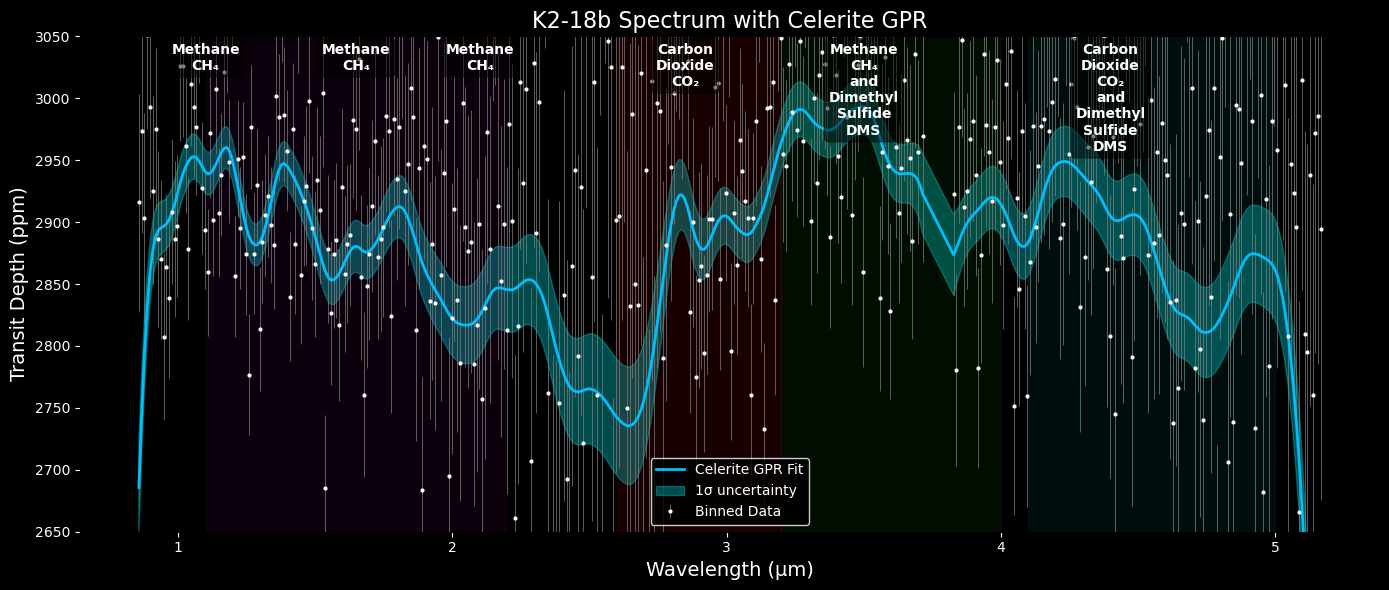

In [3]:
# -*- coding: utf-8 -*-
"""
Created on Thu Jul 17 19:03:05 2025

@author: drago
"""
# @author: drago
# Description: Load native JWST spectrum of K2-18b, bin it, and fit with Celerite GPR (Matern 3/2)
# celerit je biblioteka za gausovve procese posebno optimizovana za jednodimenzione vremenske serije (npr light curves ili radijalne brzine)
# optimizovan za brzinu umesti O(N3) radi sa O(N)

import numpy as np
import matplotlib.pyplot as plt
from celerite import GP
from celerite.terms import Matern32Term

# === LOAD NATIVE-RESOLUTION JWST DATA ===
wl_soss, depth_soss, err_soss = np.loadtxt(
    "K2-18b_niriss_soss_native.txt", usecols=(0, 2, 3), unpack=True, skiprows=1)
wl_g395, depth_g395, err_g395 = np.loadtxt(
    "K2-18b_nirspec_g395h_native.txt", usecols=(0, 2, 3), unpack=True, skiprows=1)

wavelength = np.concatenate([wl_soss, wl_g395])
depth = np.concatenate([depth_soss, depth_g395])
error = np.concatenate([err_soss, err_g395])

# === SORT & CONVERT ===
idx = np.argsort(wavelength)
wavelength = wavelength[idx]
depth_ppm = depth[idx] * 1e6
error_ppm = error[idx] * 1e6

# === BINNING ===
bin_size = 0.01
bins = np.arange(wavelength.min(), wavelength.max(), bin_size)
digitized = np.digitize(wavelength, bins)

bin_centers, binned_depth, binned_error = [], [], []
for i in range(1, len(bins)):
    mask = digitized == i
    if np.any(mask):
        bin_centers.append(np.mean(wavelength[mask]))
        binned_depth.append(np.mean(depth_ppm[mask]))
        binned_error.append(np.sqrt(np.sum(error_ppm[mask]**2)) / np.sum(mask))

X = np.array(bin_centers)
y = np.array(binned_depth)
dy = np.array(binned_error)

# === CELERITE GPR ===  gaussina process regresion

kernel = Matern32Term(log_sigma=np.log(np.std(y)), log_rho=np.log(0.2))
gp = GP(kernel)
gp.compute(X, yerr=dy)
y_pred, y_var = gp.predict(y, X, return_var=True)
y_std = np.sqrt(y_var)

# === PLOT ===
plt.figure(figsize=(14, 6))
plt.errorbar(X, y, yerr=dy, fmt='.', color='white', ecolor='gray', elinewidth=0.5, markersize=4, label='Binned Data')
plt.plot(X, y_pred, color='deepskyblue', lw=2, label='Celerite GPR Fit')
plt.fill_between(X, y_pred - y_std, y_pred + y_std, color='cyan', alpha=0.3, label='1σ uncertainty')

# === MOLECULAR ABSORPTION REGIONS ===
plt.axvspan(1.1, 2.2, color='purple', alpha=0.1)
plt.axvspan(2.6, 3.2, color='red', alpha=0.1)
plt.axvspan(3.2, 4.0, color='green', alpha=0.1)
plt.axvspan(4.1, 5.0, color='teal', alpha=0.1)

# === ANNOTATE MOLECULES (WHITE FONT) ===
labels = [
    (1.1, "Methane\nCH₄"),
    (1.65, "Methane\nCH₄"),
    (2.1, "Methane\nCH₄"),
    (2.85, "Carbon\nDioxide\nCO₂"),
    (3.5, "Methane\nCH₄\nand\nDimethyl\nSulfide\nDMS"),
    (4.4, "Carbon\nDioxide\nCO₂\nand\nDimethyl\nSulfide\nDMS")
]
for wav, label in labels:
    plt.text(wav, 3045, label, ha='center', va='top',
             fontsize=10, color='white', fontweight='bold',
             bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.3'))

# === STYLING ===
plt.gca().set_facecolor('black')
plt.gcf().patch.set_facecolor('black')
plt.xlabel('Wavelength (µm)', fontsize=14, color='white')
plt.ylabel('Transit Depth (ppm)', fontsize=14, color='white')
plt.title('K2-18b Spectrum with Celerite GPR', fontsize=16, color='white')
plt.tick_params(colors='white')
legend = plt.legend(facecolor='black', edgecolor='white', fontsize=10)
for text in legend.get_texts():
    text.set_color('white')
plt.ylim(2650, 3050)
plt.tight_layout()
plt.savefig("K2-18b_spectrum_GPR_labels.png", dpi=300)
plt.show()

![Alt Text](Spectra_of_exoplanet_K2-18_b_pillars.jpg)